In [208]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from scipy.io import loadmat, savemat
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import scipy.io as sio
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


dense_layers = [0, 1, 2, 3]
dense_sizes = [32, 64, 128, 256, 512]
conv_layers = [1, 2, 3, 4]
num_filters = [32, 64, 128, 256]
kernel_sizes = [2000, 2250, 2500, 2750, 3000]



/Users/button/Deeplearning-Autoencoder-DOA/data/result
(5000, 400)
(1000, 400)


In [ ]:
dataest = tf.data.Dataset.list_files('../data/single source_100snapshots_1000sample/*')

In [ ]:

rootPath = os.getcwd()
# Windoes path
filePath = 'C:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\data';
#  MAC path:
# filePath = '/Users/button/Deeplearning-Autoencoder-DOA/data'
savePath = filePath + '/result'

if not os.path.isdir(savePath):
    os.makedirs(savePath)
print(savePath)


dataPath = filePath + '/train/train_data.mat'
oriDataPath = filePath + '/train/origin_data.mat'
labelPath = filePath + '/train/train_label.mat'
x_train = sio.loadmat(dataPath)
y_train = sio.loadmat(oriDataPath)

dataPath = filePath + '/test/test_data.mat'
oriDataPath = filePath + '/test/origin_data.mat'
labelPath = filePath + '/test/test_label.mat'
x_test = sio.loadmat(dataPath)
y_test = sio.loadmat(oriDataPath)

# load data
x_train = x_train['train_data']  # noisy sample covariance matrix
y_train = y_train['origin_data']  # original sample covariance matrix
print(x_train.shape)

x_test = x_test['test_data']
y_test = y_test['test_origin_data']
print(x_test.shape)

In [171]:
# train_data, test_data, train_labels, test_labels = train_test_split(
#     data, labels, test_size=0.2, random_state=21
# )

# Normalize the data to [0,1]
min_val = tf.reduce_min(x_train)
max_val = tf.reduce_max(x_train)
x_train = (x_train - min_val) / (max_val-min_val)

min_val = tf.reduce_min(y_train)
max_val = tf.reduce_max(y_train)
y_train = (y_train - min_val) / (max_val-min_val)

# x_train = tf.cast(x_train, tf.float32)
# y_train = tf.cast(y_train, tf.float32)

/Users/button/Deeplearning-Autoencoder-DOA/data/result
/Users/button/Deeplearning-Autoencoder-DOA/data/result/denoised_data.mat


In [146]:
min_val = tf.reduce_min(x_test)
max_val = tf.reduce_max(x_test)
x_test = (x_test - min_val) / (max_val-min_val)

min_val = tf.reduce_min(y_test)
max_val = tf.reduce_max(y_test)
y_test = (y_test - min_val) / (max_val-min_val)

# x_test  = tf.cast(x_test, tf.float32)
# y_test  = tf.cast(y_test, tf.float32)

In [147]:
# create scaler (Normalization)
# scaler = MinMaxScaler()
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# y_train = scaler.fit_transorm(y_tra)

In [209]:
# Model configuration
nSample = x_train.shape[0]
epoch = 100
batch_size = 64
validation_split = 0.2

save_dir = os.path.join(os.getcwd(), 'save_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print(save_dir)

/Users/button/Deeplearning-Autoencoder-DOA/[2]Tensorflow/save_models


In [210]:
class DOA_Denoising(Model):
    def __init__(self):
        super(DOA_Denoising, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(300, activation='relu'),
            # layers.Dropout(0.2),
            layers.Dense(200, activation='relu'),
            # layers.Dropout(0.2),
            layers.Dense(100, activation='relu')]) # * 300 200 100
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(200, activation='relu'), #* 200 300 400
            # layers.Dropout(0.2),
            layers.Dense(300, activation='relu'),
            # layers.Dropout(0.2),
            layers.Dense(400, activation='linear')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = DOA_Denoising() 

In [211]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

In [212]:
model_name = (
    f"epoch-{epoch}-batch-{batch_size}-dense-300-200-100-time-{int(time.time())}"
)
print(model_name)

file_path = os.path.join(save_dir, model_name)
print(file_path)

# callbacks_list
callbacks_list = [
    EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=30),
    ModelCheckpoint(
        filepath=file_path,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
    ),
    TensorBoard(
        log_dir="./logs/{}".format(model_name),
        histogram_freq=1,
        write_graph=False,
        write_images=False,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="min",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,
    ),
]

autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
    x_train,
    y_train,
    epochs=epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    callbacks=callbacks_list,  #! Do not put [] around callbacks_list variable
)

autoencoder.encoder.summary()
autoencoder.decoder.summary()


epoch-100-batch-64-dense-300-200-100-time-1642786839
/Users/button/Deeplearning-Autoencoder-DOA/[2]Tensorflow/save_models/epoch-100-batch-64-dense-300-200-100-time-1642786839
Train on 4000 samples, validate on 1000 samples
Epoch 1/100
 896/4000 [=====>........................] - ETA: 3s - loss: 121.9232

2022-01-22 02:40:40.806995: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


4000/4000 [==============================] - 2s 602us/sample - loss: 27.8933 - val_loss: 0.5820
Epoch 2/100
4000/4000 [==============================] - 1s 273us/sample - loss: 0.5437 - val_loss: 0.5306
Epoch 3/100
4000/4000 [==============================] - 1s 352us/sample - loss: 0.5291 - val_loss: 0.5301
Epoch 4/100
4000/4000 [==============================] - 2s 624us/sample - loss: 0.5287 - val_loss: 0.5297
Epoch 5/100
4000/4000 [==============================] - 2s 541us/sample - loss: 0.5284 - val_loss: 0.5300
Epoch 6/100
4000/4000 [==============================] - 2s 397us/sample - loss: 0.5282 - val_loss: 0.5295
Epoch 7/100
4000/4000 [==============================] - 2s 477us/sample - loss: 0.5281 - val_loss: 0.5302
Epoch 8/100
4000/4000 [==============================] - 2s 422us/sample - loss: 0.5280 - val_loss: 0.5295
Epoch 9/100
4000/4000 [==============================] - 2s 557us/sample - loss: 0.5278 - val_loss: 0.5294
Epoch 10/100
4000/4000 [========================

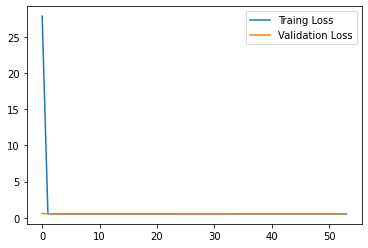

In [213]:
plt.plot(history.history["loss"], label="Traing Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('10.png')
plt.savefig('SNR_-30_training_loss.png')

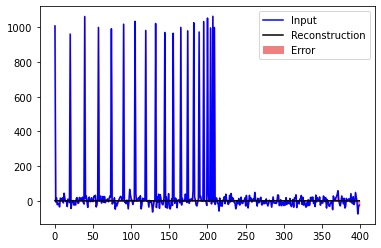

In [215]:
encoded_data = autoencoder.encoder(x_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

ind = 200
plt.plot(x_test[ind],'b')
plt.plot(decoded_data[ind],'k')
plt.fill_between(np.arange(400),decoded_data[ind],x_test[ind],color='lightcoral')
plt.legend(["Input", "Reconstruction","Error"])
plt.savefig('SNR_-30_autoencoder_compare.png')

In [216]:
print(savePath)

savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})

/Users/button/Deeplearning-Autoencoder-DOA/data/result
/Users/button/Deeplearning-Autoencoder-DOA/data/result/denoised_data.mat


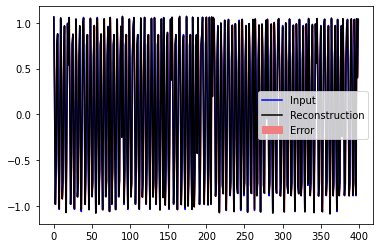

In [183]:
encoded_data = autoencoder.encoder(y_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(y_test[ind],'b')
plt.plot(decoded_data[ind],'k')
plt.fill_between(np.arange(400),decoded_data[ind],y_test[ind],color='lightcoral')
plt.legend(labels=["Input", "Reconstruction","Error"])

(1000, 400)
(1000,)


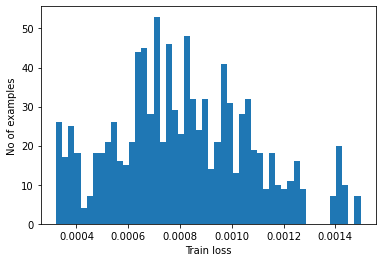

In [130]:
# Detect anomalies
reconstructions = autoencoder.predict(x_test)
print(reconstructions.shape)
train_loss = losses.mse(reconstructions, y_test)
print(train_loss.shape)
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [62]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:",threshold)

Threshold: 0.28259132755794064


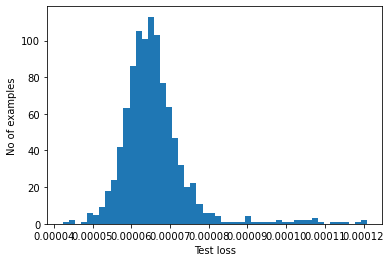

In [131]:
# reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mse(x_test, y_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()